In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')

from Q_find import Q_finder
from Q_find import charfun

###########################################################    
# Training
nclouds = 50000
npoints = 100

# The point clouds
means = torch.rand(nclouds)
covs = torch.rand(nclouds) * 0.2
normal = torch.randn(nclouds, npoints, 1)

# Ensure periodic b/c
for i in range(nclouds):
    normal[i, :, 0] = normal[i, :, 0] * covs[i] + means[i]
    normal[i, :, 0] %= 1

uniform = torch.rand(nclouds, npoints, 1)

trainset = torch.cat((normal, uniform))

# Function to calculate Q
R=0.1

# Time how long it takes to find the order parameter manually (start)
tic = time.perf_counter()

labels = Q_finder(trainset, R, npoints)

# # Time how long it takes to find the order parameter manually (end)
toc = time.perf_counter()

# Labels
labels = torch.tensor(labels).view(-1,1)

# Dataset
dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last=True)

print(f"To calculate the order parameters for training manually took {toc - tic:0.4f} seconds")

#########################################################
# Testing clouds

ncloudstest = 10000
npointstest = 100

# The point clouds
normaltest = torch.randn(ncloudstest, npointstest, 1)
uniformtest = torch.rand(ncloudstest, npointstest, 1)

means = torch.rand(ncloudstest)
covs = torch.rand(ncloudstest) * 0.2

# Periodic b/c
for i in range(ncloudstest):
    normaltest[i, :, 0] = normaltest[i, :, 0]*covs[i] + means[i]
    normaltest[i, :, 0] %= 1


testset = torch.cat((normaltest, uniformtest))
testset_keep = testset

# Time how long it takes to find the order parameter manually (start)
tic = time.perf_counter()

# Find the order parameter
labels_test = Q_finder(testset, R, npoints)

# # Time how long it takes to find the order parameter manually (end)
toc = time.perf_counter()

# Labels
testlabels = torch.tensor(labels_test).view(-1,1)
test=testset

# Dataset
testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last=True)

print(f"To calculate the order parameters for testing manually took {toc - tic:0.4f} seconds")

To calculate the order parameters for training manually took 4315.6814 seconds
To calculate the order parameters for testing manually took 1557.1305 seconds


In [4]:
class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, train = True):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        #x = F.relu(x)
        
        return x

In [5]:
############################################################
net = PointNetCls(k=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
nepochs = 30

train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()
        
        with torch.no_grad():
            epoch_test_loss += criterion(net(testset_keep), testlabels).item()

        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
        counter += 1
    
    train_loss[epoch] = epoch_train_loss/counter
    test_loss[epoch] = epoch_test_loss/counter
    epoch_train_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.028
[1,   400] loss: 0.009
[1,   600] loss: 0.008
[1,   800] loss: 0.008
[1,  1000] loss: 0.007
[1,  1200] loss: 0.006
[1,  1400] loss: 0.006
[2,   200] loss: 0.008
[2,   400] loss: 0.007
[2,   600] loss: 0.006
[2,   800] loss: 0.006
[2,  1000] loss: 0.005
[2,  1200] loss: 0.006
[2,  1400] loss: 0.006
[3,   200] loss: 0.007
[3,   400] loss: 0.006
[3,   600] loss: 0.005
[3,   800] loss: 0.005
[3,  1000] loss: 0.005
[3,  1200] loss: 0.006
[3,  1400] loss: 0.007
[4,   200] loss: 0.005
[4,   400] loss: 0.005
[4,   600] loss: 0.004
[4,   800] loss: 0.005
[4,  1000] loss: 0.005
[4,  1200] loss: 0.005
[4,  1400] loss: 0.004
[5,   200] loss: 0.006
[5,   400] loss: 0.005
[5,   600] loss: 0.005
[5,   800] loss: 0.004
[5,  1000] loss: 0.005
[5,  1200] loss: 0.004
[5,  1400] loss: 0.004
[6,   200] loss: 0.004
[6,   400] loss: 0.004
[6,   600] loss: 0.003
[6,   800] loss: 0.004
[6,  1000] loss: 0.005
[6,  1200] loss: 0.004
[6,  1400] loss: 0.005
[7,   200] loss: 0.004
[7,   400] 

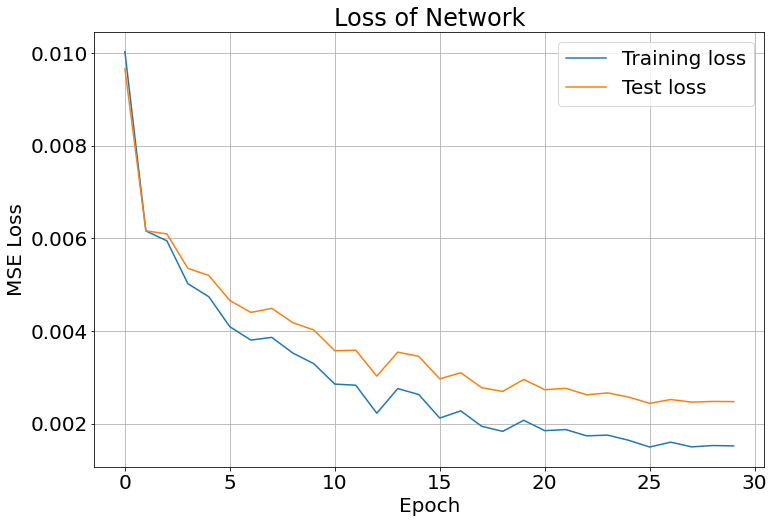

In [6]:
font = {'size'   : 20}

x = np.arange(nepochs)
plt.figure(figsize=(12,8))
plt.rc('font', **font)
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, test_loss, label='Test loss')
plt.legend()
plt.grid()
plt.title('Loss of Network')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.savefig('Loss1D_find_nodropout_2.jpeg', bbox_inches ='tight')
plt.show()

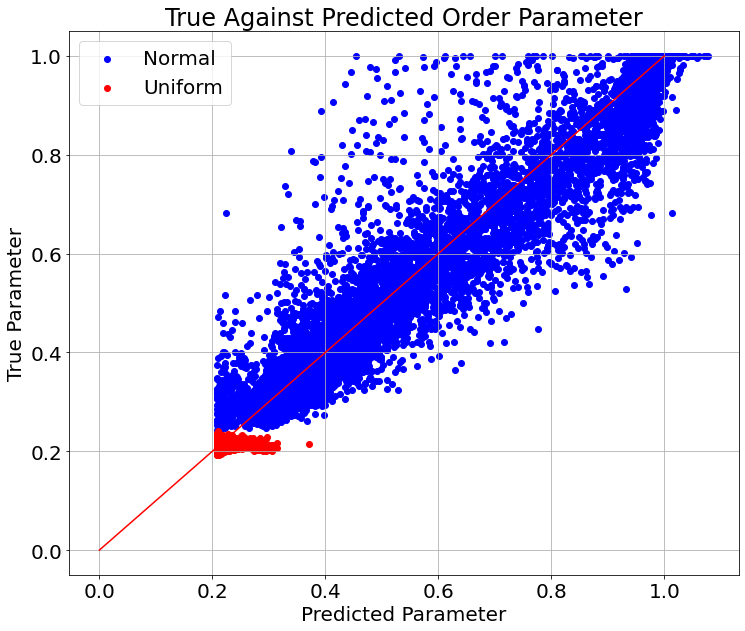

To calculate the order using PointNet took 0.3905 seconds for 10000 test clouds


In [7]:
# Timer start
tic = time.perf_counter()

outputs = net(test)

# Timer end
toc = time.perf_counter()

x = outputs.detach().numpy()
y = labels_test

# plot the data

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(111)
ax1.scatter(x[:ncloudstest], y[:ncloudstest],  c='b', label='Normal')
ax1.scatter(x[ncloudstest:],y[ncloudstest:],  c='r', label='Uniform')
plt.legend(loc='upper left')
plt.plot(np.linspace(0, 1, 10), np.power(np.linspace(0, 1, 10), 1), color = 'r', label = 'y = x')
plt.grid()
font = {'size'   : 20}
plt.rc('font', **font)
plt.title("True Against Predicted Order Parameter")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.savefig('TruevPred1Dcol_nodropout_2.jpeg', bbox_inches ='tight')
plt.show()

print(f"To calculate the order using PointNet took {toc - tic:0.4f} seconds for {ncloudstest:1.0f} test clouds")

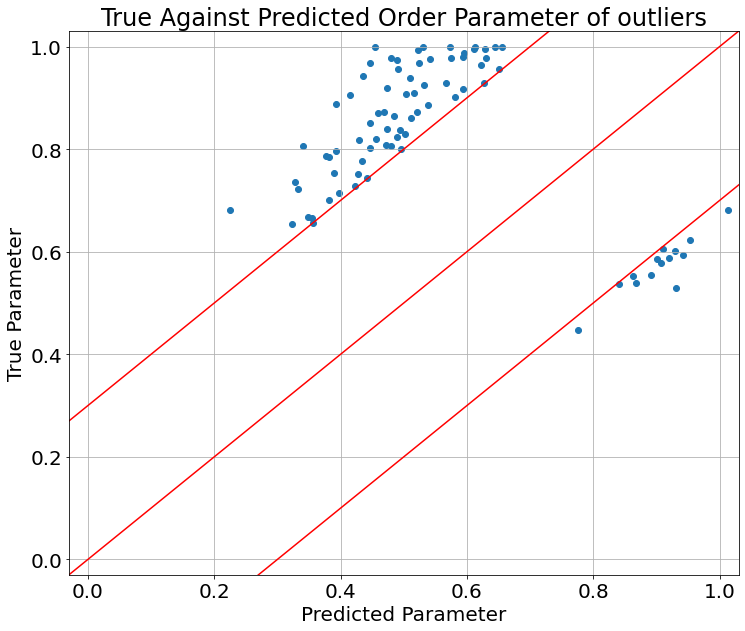

In [11]:
# Outliers 
y = np.array(y)
outlier_ind = []
for i in range(len(x)):
    if np.abs(x[i]-y[i])>0.3:
        outlier_ind.append(i)

# plot the outliers only
plt.figure(figsize=(12,10))
plt.scatter(x[outlier_ind],y[outlier_ind])
plt.plot(np.linspace(-1, 2, 10), np.linspace(-1, 2, 10), color = 'r', label = 'y = x')
plt.plot(np.linspace(-1, 2, 10), np.linspace(-1, 2, 10)+0.3, color = 'r', label = 'y = x')
plt.plot(np.linspace(-1, 2, 10), np.linspace(-1, 2, 10)-0.3, color = 'r', label = 'y = x')
plt.grid()
plt.title("True Against Predicted Order Parameter of outliers")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.xlim([-0.03,1.03])
plt.ylim([-0.03,1.03])
font = {'size'   : 20}
plt.rc('font', **font)
plt.savefig('TruevPredoutliers_nomult_2.jpeg', bbox_inches ='tight')
plt.show()

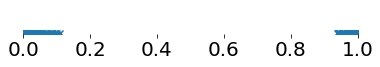

82


In [9]:
# Plotting the outlier and printing it's true and predicted order parameters
# example ind = 0
fig1 = plt.figure(facecolor='white', figsize =(6,0.5))
ax1 = plt.axes(frameon=False)
ax1.set_frame_on(False)
ax1.get_xaxis().tick_bottom()
ax1.axes.get_yaxis().set_visible(False)
plt.xlim(0,1)
plt.ylim(-0.05,1)
#plt.axis('off')  # command for hiding the axis. 
plt.scatter(test[outlier_ind[44]],np.zeros(npoints), marker = "x")
plt.savefig('OutlierEx6.jpeg', bbox_inches ='tight')
plt.show()
print(np.size(outlier_ind))